<a href="https://colab.research.google.com/github/chenwh0/Natural-Language-Processing-work/blob/main/module6/HowTokenizationAndEmbeddingsWorksInsideLLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exploration and Analysis of Tokenization and Embeddings in Modern LLMs**

**Background:**  
This lab tested how multiple real tokenizers operate, dissected how their output impacts the resulting embeddings, and analyzed why these choices matter for both accuracy and efficiency in language tasks.

# *Sources/References*

* Academic Data source: https://pubmed.ncbi.nlm.nih.gov/18270555/

### Instructions & Deliverables

#### 1. **Tokenization Deep Dive (2 points)**

- Select *five diverse sentences*:  
  - Two with formal academic language  
  - One with slang or social media language  
  - One with an emoji  
  - One with code/math notation  
- For each sentence, tokenize with **three different pretrained tokenizers** (choose from e.g. `bert-base-uncased`, `gpt2`, `microsoft/Phi-3-mini-4k-instruct`, `google/flan-t5-small`, etc.).
- Display for each:
  - The original text
  - The sequence of tokens and their decoded forms (subwords)
  - The token IDs

#### 2. **Cross-Tokenizer Comparison (2 points)**

- Place your results in a **comparison table**:
  - For each sentence and tokenizer, show:  
    - Number of tokens  
    - How words or special features (names/emoji/code) are split
    - Presence of [UNK] or unknown tokens
- In a *markdown cell*, answer:  
  - Which tokenization schemes are more robust to slang, emojis, and code?  
  - Which produce the longest and shortest sequences? Why?

#### 3. **Token Embedding Visualization (3 points)**

- Pick one sentence and one tokenizer from your previous results.
- Use the tokenizer’s pretrained embedding layer (from its associated model) to produce the embedding vector for each token in the sentence.
- Use PCA or t-SNE to project the token embeddings to 2D and create a **scatter plot**:
  - Each point should be labeled with the decoded token.
  - Color points differently for subwords, whole words, and special tokens.
- Comment on the geometry: Do related words/subwords cluster? Are special tokens outliers?

#### 4. **Prompt Engineering & Model Output (2 points)**

- Take two tokenized prompts that yielded notably different token splits across tokenizers (e.g. one with code/math and one with informal language).
- For each:
  - Use two *different* language models (“matching” the tokenizer used) to generate text completions.
  - In a short table, report:
    - Length (in tokens and characters) of the generated output
    - Are any [UNK] tokens, empty outputs, or odd/non-conversational results observed?
- Discuss how the tokenizer choice might affect downstream output quality and efficiency.

#### 5. **Reflection (1 point)**

- In a paragraph (markdown), summarize:
  - How does the choice of tokenizer and embedding scheme affect which kinds of input a model can “understand”?
  - Why must LLM practitioners consider both the *efficiency* (sequence length) and the *semantic coverage* (handling unknowns, subwords, emoji) of each tokenizer?

**Submission**:  
Produce a Jupyter notebook with clearly separated code and markdown cells for each section. All code must run under Python and Hugging Face Transformers. Include all required tables, plots, and discussion.

**Grading Rubric:**

| Section                           | Points |
|:-----------------------------------|:------:|
| Tokenization Deep Dive             | 2      |
| Cross-Tokenizer Comparison Table & Analysis | 2 |
| Embedding Visualization            | 3      |
| Prompt Engineering & Model Output  | 2      |
| Reflection                        | 1      |
| **Total**                         | **10** |

# *Installs & Imports*

In [1]:
# Data preprocessing libraries
import pandas

# Tokenizer library
from transformers import AutoModelForCausalLM, AutoTokenizer

# Data visualization
import matplotlib.pyplot as pyplot

In [2]:
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. **Tokenization Deep Dives**

a. Selected *5 diverse sentences*
  - 2 with formal academic language  
  - 1 with slang or social media language  
  - 1 with an emoji  
  - 1 with code/math notation  

b. Tokenized each sentence with **3 different pretrained tokenizers** (`bert-base-uncased`, `gpt2`, `microsoft/Phi-3-mini-4k-instruct`).

c. Displayed for each sentence:
  - The original text
  - The sequence of tokens and their decoded forms (subwords)
  - The token IDs

In [3]:
texts = [
    "New methodologies and prototype systems for dynamically incorporating automatic feature extraction, visual selection, and knowledge-rich semantics for content-based image database management and retrieval are needed to assist image analysts.",
    "GeoIRIS can be best described by its architecture as shown in Fig. 1. There are six modules: feature extraction (FE), indexing structures (IS), semantic framework (SF), GeoName server (GS), fusion and ranking (FR), and retrieval visualization (RV).",
    "If I get one more L I'm gonna yeet my controller out a window no cap",
    "One will need a 🖥️ first to make a 🌏 application.",
    "To ensure features are rotationally insensitive, we order each bin, i ∈ [1, F], from W+y and W−y, such that S[i] = max {W +yi , W −yi } and S[i + F] = min {W +yi , W −yi }"
]

In [4]:
# List of RGB color codes for highlighting tokens in the output
colors_list = [
    '102;194;165', '252;141;98', '141;160;203',
    '231;138;195', '166;216;84', '255;217;47'
]

def show_tokens(sentence, tokenizer):
    # Tokenize the input sentence and get token IDs
    token_ids = tokenizer(sentence).input_ids
    print("Original text:", sentence)
    tokenized_prompt = []
    # Iterate over each token ID and print the decoded token with colored background
    for idx, t in enumerate(token_ids):
        text = tokenizer.decode(t)
        print(
            # ANSI escape code for colored background using RGB values from colors_list
            f'\x1b[0;30;48;2;{colors_list[idx % len(colors_list)]}m' +
            text +
            '\x1b[0m',
            end=' '
        )
        #tokenized_prompt.append((text, t))

    print("\nToken IDs:", token_ids)
    print()
    return token_ids

In [5]:
def tokenizer_split(tokenizer_name, texts):
    tokenized_prompts = []
    for text in texts:
        token_ids = show_tokens(text, tokenizer_name)
        tokenized_prompts.append(token_ids)
    return tokenized_prompts

In [6]:
# Load the specified tokenizer from Hugging Face
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
gpt2_tokenizer = AutoTokenizer.from_pretrained("gpt2")
phi3_tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

In [7]:
bert_tokenized_prompts = tokenizer_split(bert_tokenizer, texts)

Original text: New methodologies and prototype systems for dynamically incorporating automatic feature extraction, visual selection, and knowledge-rich semantics for content-based image database management and retrieval are needed to assist image analysts.
[CLS] new method ##ologies and prototype systems for dynamic ##ally incorporating automatic feature extraction , visual selection , and knowledge - rich semantics for content - based image database management and retrieval are needed to assist image analysts . [SEP] 
Token IDs: [101, 2047, 4118, 20792, 1998, 8773, 3001, 2005, 8790, 3973, 13543, 6882, 3444, 14676, 1010, 5107, 4989, 1010, 1998, 3716, 1011, 4138, 28081, 2005, 4180, 1011, 2241, 3746, 7809, 2968, 1998, 26384, 2024, 2734, 2000, 6509, 3746, 18288, 1012, 102]

Original text: GeoIRIS can be best described by its architecture as shown in Fig. 1. There are six modules: feature extraction (FE), indexing structures (IS), semantic framework (SF), GeoName server (GS), fusion and ra

In [8]:
gpt2_tokenized_prompts = tokenizer_split(gpt2_tokenizer, texts)

Original text: New methodologies and prototype systems for dynamically incorporating automatic feature extraction, visual selection, and knowledge-rich semantics for content-based image database management and retrieval are needed to assist image analysts.
New  method ologies  and  prototype  systems  for  dynamically  incorporating  automatic  feature  extraction ,  visual  selection ,  and  knowledge - rich  semantics  for  content - based  image  database  management  and  retrieval  are  needed  to  assist  image  analysts . 
Token IDs: [3791, 2446, 5823, 290, 14879, 3341, 329, 32366, 29927, 11353, 3895, 22236, 11, 5874, 6356, 11, 290, 3725, 12, 7527, 33815, 329, 2695, 12, 3106, 2939, 6831, 4542, 290, 45069, 389, 2622, 284, 3342, 2939, 13440, 13]

Original text: GeoIRIS can be best described by its architecture as shown in Fig. 1. There are six modules: feature extraction (FE), indexing structures (IS), semantic framework (SF), GeoName server (GS), fusion and ranking (FR), and retr

In [9]:
phi3_mini4K_tokenized_prompts = tokenizer_split(phi3_tokenizer, texts)

Original text: New methodologies and prototype systems for dynamically incorporating automatic feature extraction, visual selection, and knowledge-rich semantics for content-based image database management and retrieval are needed to assist image analysts.
New method ologies and prototype systems for dynamically incorpor ating automatic feature extra ction , visual selection , and knowledge - rich semantics for content - based image database management and retr ieval are needed to assist image anal yst s . 
Token IDs: [1570, 1158, 11763, 322, 22267, 6757, 363, 11200, 11039, 1218, 18428, 4682, 4805, 428, 29892, 7604, 9262, 29892, 322, 7134, 29899, 4018, 29505, 363, 2793, 29899, 6707, 1967, 2566, 10643, 322, 5663, 16837, 526, 4312, 304, 6985, 1967, 3483, 858, 29879, 29889]

Original text: GeoIRIS can be best described by its architecture as shown in Fig. 1. There are six modules: feature extraction (FE), indexing structures (IS), semantic framework (SF), GeoName server (GS), fusion and r

# 2. **Cross-Tokenizer Comparison**

## Tokenization scheme more robuts to slang, emojis, code

Phi-3-mini-4k-instruct is more robust for emojis and math symbols because it had the ability of understanding emojis as well as the math symbol ∈

## Tokenization scheme that produced longest/shortest sequences
GPT2 produced the shortest sequence overall & Phi-3-mini-4k-instruct produced the longest sequence overall. This might be because GPT2 is least aggressive in its word splits and Phi-3-mini-4k-instruct is the most aggressive in word-splits

In [ ]:
def calculate_variables(name, tokenized_prompts, emoji_split, unk_token):
    total_tokens = 0
    total_unk = 0
    for prompt in tokenized_prompts:
        total_tokens += len(prompt)
        total_unk += prompt.count(unk_token)

    row = {"Tokenizer name": name, "# of tokens": total_tokens,
           "emoji split": emoji_split, "Unknown tokens count": total_unk}
    return row

In [ ]:
row1 = calculate_variables("BERT uncased", bert_tokenized_prompts, "[UNK]", 100)
row2 = calculate_variables("GPT2", gpt2_tokenized_prompts, " � � �", 50256)
row3 = calculate_variables("Phi-3-mini-4k-instruct", phi3_mini4K_tokenized_prompts, "� � � �",32000)
comparison_dataframe = pandas.DataFrame([row1, row2, row3])
display(comparison_dataframe)

,Tokenizer name,# of tokens,emoji split,Unknown tokens count
0,BERT uncased,209,[UNK],2
1,GPT2,195,� � �,0
2,Phi-3-mini-4k-instruct,212,� � � �,0


# 3. **Token Embedding Visualization**

a. Selected last sentence of math equations & symbols: *"To ensure features are rotationally insensitive, we order each bin, i ∈ [1, F], from W+y and W−y, such that S[i] = max {W +yi , W −yi } and S[i + F] = min {W +yi , W −yi }"*

b. Used the tokenizer’s pretrained embedding layer (from its associated model) to produce the embedding vector for each token in the sentence.

c. Used PCA to project the token embeddings to 2D

d.Visualized via **scatter plot** with different color for special token (orange) vs subword (pink) vs full word (blue) tokens

## Scatterplot findings
* BERT clustered "*min*" and "*max*" close to each other because of their similarity in meaning
* GPT2 clustered "*max*" closer to its neighbor letters from the original sentence.

* BERT seemed to cluster tokens of similar meanings together.
* GPT2 seemed to cluster based on token's position in senttence.

In [17]:
def get_token_embeddings(tokenizer, text, model):
    token_ids = tokenizer(text, return_tensors="pt")
    with torch.no_grad(): # Embeddings are at the last hidden state from model
        outputs = model(**token_ids)
        token_embeddings = outputs.last_hidden_state
    print(f"Token embeddings:\n{token_embeddings}")
    return token_ids, token_embeddings

In [15]:
bert_model = AutoModel.from_pretrained("bert-base-uncased")
gpt2_model = AutoModel.from_pretrained("gpt2")

bert_token_ids, bert_embeddings = get_token_embeddings(bert_tokenizer, texts[-1], bert_model)
gpt2_token_ids, gpt2_embeddings = get_token_embeddings(gpt2_tokenizer, texts[-1], gpt2_model)

Token embeddings:
tensor([[[-0.1293, -0.4475, -0.0846,  ..., -0.0986, -0.1473,  1.1275],
         [ 0.4332,  0.3684, -0.9994,  ...,  0.1272,  0.8578, -0.0424],
         [ 0.1929, -0.1292,  0.1140,  ..., -0.2777, -0.1733,  0.2302],
         ...,
         [ 0.5504, -1.1513,  0.8097,  ..., -0.2639, -0.1655,  0.4061],
         [-0.3980, -0.6015,  0.5670,  ..., -0.2304, -0.6121, -0.1730],
         [ 0.6549,  0.0938, -0.1077,  ...,  0.4860, -0.6815, -0.3300]]])
Token embeddings:
tensor([[[-1.6730e-02,  1.8037e-02, -1.8657e-01,  ..., -2.8187e-01,
          -2.7035e-02, -7.9684e-02],
         [-5.0982e-01, -1.0083e-01,  2.4405e-01,  ...,  7.8806e-02,
           9.5911e-02, -2.2414e-01],
         [ 9.4878e-04,  3.5486e-02, -1.6985e+00,  ...,  3.3101e-01,
          -1.4450e-01,  3.1860e-01],
         ...,
         [ 6.0901e-01, -6.4668e-01, -8.3682e-01,  ..., -4.6591e-01,
          -3.5840e-02, -2.1471e-01],
         [ 5.6379e-01, -5.0438e-01, -8.0031e-01,  ..., -4.9332e-01,
           4.7319e-0

In [25]:
def pca_reduce(token_embeddings, dimensions=2):
    # Reduce embeddings to 2D using PCA
    pca = PCA(n_components=dimensions)
    # Reshape token_embeddings from (batch_size, sequence_length, hidden_size) to (sequence_length, hidden_size)
    embeddings_2d = pca.fit_transform(token_embeddings.squeeze(0))
    return embeddings_2d

def scatterplot(tokenizer, token_ids, embeddings_2d, tokenizer_name=""):
    print(f"{tokenizer_name} tokenization")
    tokens = [tokenizer.decode([token_id]) for token_id in token_ids['input_ids'][0]] # Decode tokens back to words using input ids

    # Determine token type for coloring based on BERT's tokenization
    colors = []
    for token in tokens:
        if token.startswith("[") and token.endswith("]") or "�" in token: # Special tokens like [CLS], [SEP], [UNK], or �
            colors.append("orange")
        elif token.startswith("##"): # Subwords in WordPiece (BERT)
            colors.append("pink")
        else: # Whole words
            colors.append("skyblue")

    # Plot
    plt.figure(figsize=(14, 6))
    for i, (x, y) in enumerate(embeddings_2d):
        plt.scatter(x, y, color=colors[i])
        plt.text(x, y, tokens[i], fontsize=6)
    plt.title(f"{tokenizer_name} token embeddings Projected to 2D")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")

    # Legend
    plt.scatter([], [], color="orange", label="Special Token")  # Orange = Special tokens
    plt.scatter([], [], color="pink", label="Subword")         # Pink = Subwords
    plt.scatter([], [], color="skyblue", label="Whole Word")   # Skyblue = Whole words
    plt.legend()

    plt.show()
    print("\n\n")

Original sentence: 'To ensure features are rotationally insensitive, we order each bin, i ∈ [1, F], from W+y and W−y, such that S[i] = max {W +yi , W −yi } and S[i + F] = min {W +yi , W −yi }'

BERT tokenization


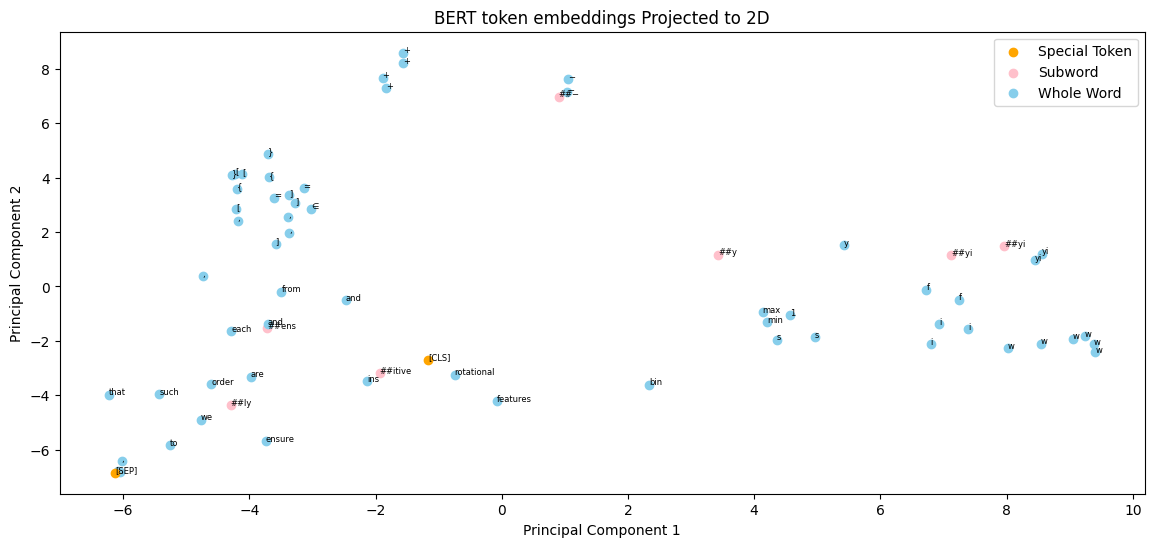




GPT2 tokenization


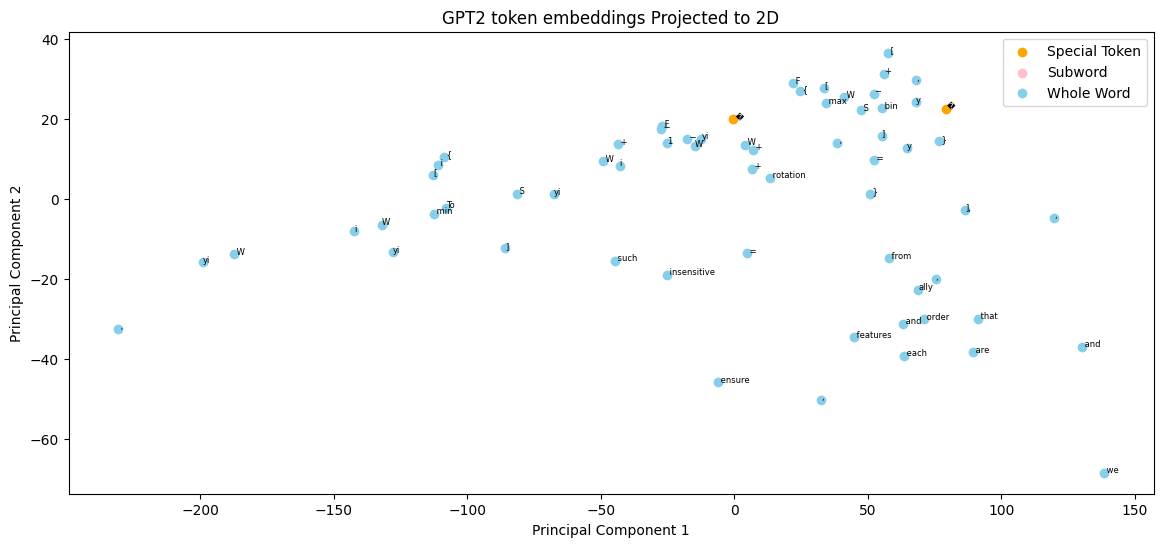

In [30]:
print(f"Original sentence: '{texts[-1]}'\n")
bert_embeddings_2d = pca_reduce(bert_embeddings, dimensions=2)
gpt2_embeddings_2d = pca_reduce(gpt2_embeddings, dimensions=2)

scatterplot(bert_tokenizer, bert_token_ids, bert_embeddings_2d, tokenizer_name="BERT")
scatterplot(gpt2_tokenizer, gpt2_token_ids, gpt2_embeddings_2d, tokenizer_name="GPT2")

# 4. **Prompt Engineering & Model Output (2 points)**

- Take two tokenized prompts that yielded notably different token splits across tokenizers (e.g. one with code/math and one with informal language).
- For each:
  - Use two *different* language models (“matching” the tokenizer used) to generate text completions.
  - In a short table, report:
    - Length (in tokens and characters) of the generated output
    - Are any [UNK] tokens, empty outputs, or odd/non-conversational results observed?

## how tokenizer choice affects downstream output quality & efficiency

BERT - They are efficient for retrieval because they use the least amount of tokens to represent texts compared to other tokenizers, however they can not retrieve unicode & emojis as well. In generation tasks, they are good for classification but may have trouble with capitalization.

GPT2 - They are good for retrieval because they can handle unknown words by breaking them down into subwords, and they have some representations for unicode & emojis, but required to search through more tokens. In generation tasks, they are sensitive to spacing.

Phi-3-mini-4k-instruct - They are efficient for retrieval because they use the least amount of tokens to represent texts compared to other tokenizers, and they can retrieve unicode & emojis. In generation tasks, they consider capitalization & can have a more global view than WordPiece BERT.

# **Technical Reflection**

## Tokenizer choice affects which types of input a model can "understand"

BERT uses WordPiece. WordPiece uses [UNK] token to represent unseen emojis, breaks math expressions down by characters, has basic tokenization skills for code syntax, and ignores capitalization in tokenization of proper nouns.

GPT2 uses Byte-Pair Encoding (BPE). BPE breaks unseen emojis further down as subunits of their Unicode representations, breaks unseen math expressions down by characters, have a better tokenization of code syntax than WordPiece, and can represent capitalization in tokenization of proper nouns.

## Efficiency vs Semantic coverage tradeoffs
In some cases, more efficient tokenizers capture less meaning and do not have high semantic coverage for all-purpose use cases while more robust semantic coverage tokenizers capture finer meaning but have higher computational and time costs in training.
